In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import scipy.stats as st

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.font_manager
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score

from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pydotplus
import joblib

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None


In [2]:
df_preprocesado = pd.read_csv('df_preprocesado.csv')
df_pca = pd.read_csv('df_pca.csv')

## 3. Clasificación

### a) Construcción del target

In [3]:
df_target = df_preprocesado.copy()
df_target_pca = df_pca.copy()

#### Creación de las nuevas columnas

Iniciamos creando la nueva variable cualitativa `tipo_precio`, la cual será la variable target posteriormente.

In [4]:
df_target["tipo_precio"] = ""
df_target_pca["tipo_precio"] = ""

In [5]:
df_target.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,


Calculamos el precio por metro cuadrado de cada propiedad y lo guardamos en una nueva variable cuantitativa `pxm2`

In [6]:
lista=[]
for i in range(len(df_target)):
    aux= (df_target.iloc[i]['property_price'])/(df_target.iloc[i]['property_surface_total'])
    lista.append(aux)

In [7]:
df_target["pxm2"] = lista

In [8]:
df_target.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,,1429.310345
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,,1414.285714
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,,1173.551114
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,,2559.558895
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,,1639.344262


#### Distribucion de la nueva variable

Graficamos la distribución de la variable precio por metro cuadrado (en general)

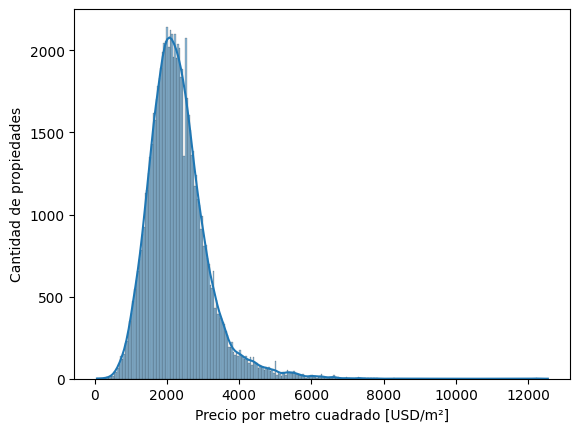

In [9]:
sns.histplot(data=df_target['pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades")
plt.show()

Ahora procedemos a graficar la distribución de la misma variable, pero solamente según el tipo de propiedad:

- Propiedad tipo casa:

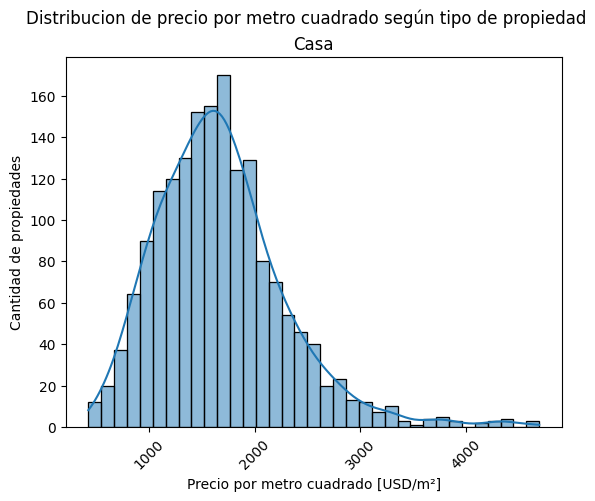

In [10]:
plt.suptitle('Distribucion de precio por metro cuadrado según tipo de propiedad')

properties_with_house_type_cond = df_target['property_type']  == 'Casa'
sns_hist=sns.histplot(data=df_target.loc[properties_with_house_type_cond,'pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades", title="Casa")
plt.xticks(rotation=45)
plt.show()

- Propiedad tipo PH:

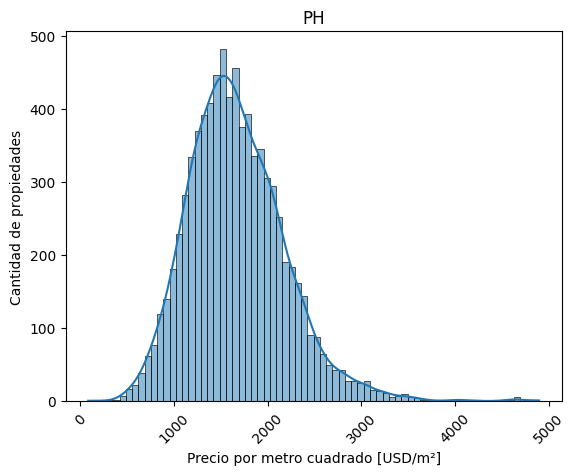

In [11]:


properties_with_PH_type_cond = df_target['property_type']  == 'PH'
sns_hist=sns.histplot(data=df_target.loc[properties_with_PH_type_cond,'pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades", title="PH")
plt.xticks(rotation=45)
plt.show()

- Propiedad tipo Departamento:

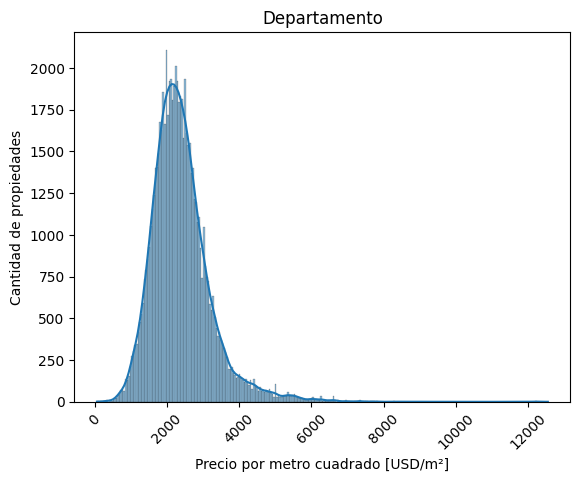

In [12]:
properties_with_dept_type_cond = df_target['property_type']  == 'Departamento'
sns_hist=sns.histplot(data=df_target.loc[properties_with_dept_type_cond,'pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades", title="Departamento")
plt.xticks(rotation=45)
plt.show()


Una vez ya creada la nueva columna tipo_precio procedemos a clasificar en Alto, medio y bajo teniendo en cuenta el precio x metro cuadrado de cada propiedad.

Para esto evaluaremos las alternativas propuestas por el enunciado para establecer los límites de cada categoría.


Primero procedemos con la separacion de train y test

In [13]:
excluir = [
    'property_price',
    'start_date',
    'place_l3',
    'property_title',
]
categories=["bajo","medio","alto"]
cols = list(set(df_target.columns) - set(excluir))
ds_trabajo_x = df_target[cols].copy()
ds_trabajo_y = df_target["tipo_precio"].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2) #semilla

hacemos lo mismo para el dataset de pca:

In [14]:
cols_pca = ['cp1','cp2']
ds_trabajo_x_pca = df_target_pca[cols_pca].copy()
ds_trabajo_y_pca = df_target["tipo_precio"].copy()

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(ds_trabajo_x_pca,
                                                    ds_trabajo_y_pca, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2) #semilla

#### Evaluación y decisión de criterio para clasificación de variable target

Se realizarán las divisiones dadas por los criterios propuestos por el enunciado sobre los datos de train de ambos datasets, para obtener los umbrales de precio correspondientes a los limites de la variable target (`tipo_precio`).

Tras decidir entre alguno de los tres criterios se aplicará dicha división a los datos de tests, para no filtrar información basado en los mismos.

##### 1. Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

In [15]:
x_train["pxm2_intervalos_iguales"], retbins = pd.qcut(x_train["pxm2"],q=3, labels=categories, retbins=True)

In [16]:
x_train.pxm2_intervalos_iguales

34834     bajo
64421     alto
77543    medio
60089    medio
77315     bajo
         ...  
80232     bajo
33867     bajo
31019    medio
44566    medio
72173    medio
Name: pxm2_intervalos_iguales, Length: 66284, dtype: category
Categories (3, object): ['bajo' < 'medio' < 'alto']

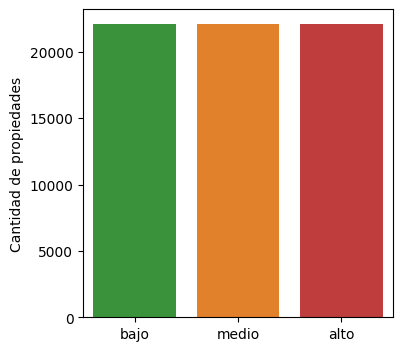

In [17]:
plt.figure(figsize=(4,4))
sns.barplot(data=x_train  , x= x_train.groupby(['pxm2_intervalos_iguales']).count().index.tolist() , y=x_train.groupby(['pxm2_intervalos_iguales']).count()['pxm2'].tolist() , palette = ['tab:green', 'tab:orange', 'tab:red']).set(ylabel='Cantidad de propiedades')
plt.show()

In [18]:
print("Las propiedades con precios asignados como BAJOS (precio < %.2f) corresponden a 1/3 del total = %d" % (retbins[1],x_train['pxm2_intervalos_iguales'].value_counts()['bajo']))
print("\nLas propiedades con precios asignados como MEDIOS (%.2f < precio < %.2f) corresponden a 1/3 del total = %d" % (retbins[1],retbins[2],x_train['pxm2_intervalos_iguales'].value_counts()['medio']))
print("\nLas propiedades con precios asignados como ALTOS (precio > %.2f) corresponden a 1/3 del total = %d" % (retbins[2],x_train['pxm2_intervalos_iguales'].value_counts()['alto']))

Las propiedades con precios asignados como BAJOS (precio < 1921.79) corresponden a 1/3 del total = 22097

Las propiedades con precios asignados como MEDIOS (1921.79 < precio < 2510.30) corresponden a 1/3 del total = 22092

Las propiedades con precios asignados como ALTOS (precio > 2510.30) corresponden a 1/3 del total = 22095


##### 2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,el siguiente con el 50% y el último con el 25% de las observaciones restantes.

In [19]:
x_train["pxm2_intervalos_25p_50p_25p"], retbins = pd.qcut(x_train["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4, retbins=True)

In [20]:
x_train.head()

,latitud,property_rooms,property_type,property_surface_covered,property_bedrooms,tipo_precio,longitud,pxm2,property_surface_total,pxm2_intervalos_iguales,pxm2_intervalos_25p_50p_25p
34834,-34.568592,1.0,Departamento,32.0,1.0,,-58.489876,1043.120510,62.313030,bajo,bajo
64421,-34.585117,4.0,Departamento,159.0,3.0,,-58.398128,3462.464049,171.842939,alto,alto
77543,-34.597790,2.0,Departamento,42.0,1.0,,-58.431483,2056.603774,53.000000,medio,medio
60089,-34.596583,1.0,Departamento,37.0,1.0,,-58.411316,2313.372093,43.000000,medio,medio
77315,-34.609066,1.0,Departamento,30.0,1.0,,-58.427785,1155.341435,60.588150,bajo,bajo


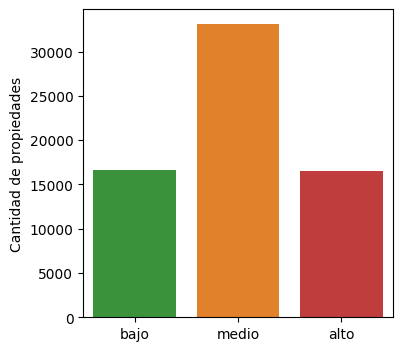

In [21]:
plt.figure(figsize=(4,4))
sns.barplot(data=x_train  , x= x_train.groupby(['pxm2_intervalos_25p_50p_25p']).count().index.tolist() , y=x_train.groupby(['pxm2_intervalos_25p_50p_25p']).count()['pxm2'].tolist() , palette = ['tab:green', 'tab:orange', 'tab:red']).set(ylabel='Cantidad de propiedades')
plt.show()

In [22]:
ds_group1 = x_train.groupby(['pxm2_intervalos_25p_50p_25p']).count() 
ds_group1

,latitud,property_rooms,property_type,property_surface_covered,property_bedrooms,tipo_precio,longitud,pxm2,property_surface_total,pxm2_intervalos_iguales
pxm2_intervalos_25p_50p_25p,,,,,,,,,,
bajo,16597,16597,16597,16597,16597,16597,16597,16597,16597,16597
medio,33117,33117,33117,33117,33117,33117,33117,33117,33117,33117
alto,16570,16570,16570,16570,16570,16570,16570,16570,16570,16570


In [23]:
print("Los departamentos con precios asignados como BAJOS (precio < %.2f) corresponden a 1/4 del total = %d" % (retbins[1],x_train['pxm2_intervalos_25p_50p_25p'].value_counts()['bajo']))
print("\nLos departamentos con precios asignados como MEDIOS (%.2f < precio < %.2f) corresponden a 1/2 del total = %d" % (retbins[1],retbins[2],x_train['pxm2_intervalos_25p_50p_25p'].value_counts()['medio']))
print("\nLos departamentos con precios asignados como ALTOS (precio > %.2f) corresponden a 1/4 del total = %d" % (retbins[2],x_train['pxm2_intervalos_25p_50p_25p'].value_counts()['alto']))


Los departamentos con precios asignados como BAJOS (precio < 1769.23) corresponden a 1/4 del total = 16597

Los departamentos con precios asignados como MEDIOS (1769.23 < precio < 2703.70) corresponden a 1/2 del total = 33117

Los departamentos con precios asignados como ALTOS (precio > 2703.70) corresponden a 1/4 del total = 16570


##### 3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en el punto anterior.

Dividimos las filas segun tipo de propiedad y las guardamos en distintos datasets

In [24]:
ds_dpto = x_train.loc[x_train["property_type"]=="Departamento"]
ds_ph = x_train.loc[x_train["property_type"]=="PH"]
ds_casa = x_train.loc[x_train["property_type"]=="Casa"]

Analizamos primero los departamentos

In [25]:
ds_dpto["pxm2_dpto_intervalos_25p_50p_25p"], retbins_dpto = pd.qcut(ds_dpto["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4, retbins=True)
ds_dpto["tipo_precio"]= ds_dpto["pxm2_dpto_intervalos_25p_50p_25p"].values

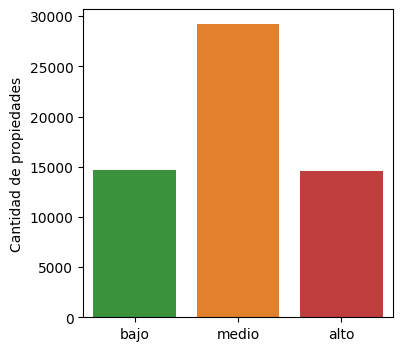

In [26]:
plt.figure(figsize=(4,4))
sns.barplot(data=ds_dpto  , x=ds_dpto.groupby(['pxm2_dpto_intervalos_25p_50p_25p']).count().index.tolist() , y=ds_dpto.groupby(['pxm2_dpto_intervalos_25p_50p_25p']).count()['pxm2'].tolist(), palette = ['tab:green', 'tab:orange', 'tab:red'] ).set(ylabel='Cantidad de propiedades')
plt.show()

In [27]:
print("Las propiedades con precios asignados como BAJOS (precio < %.2f) corresponden a 1/4 del total = %d" % (retbins_dpto[1],ds_dpto['pxm2_dpto_intervalos_25p_50p_25p'].value_counts()['bajo']))
print("\nLas propiedades con precios asignados como MEDIOS (%.2f < precio < %.2f) corresponden a 1/2 del total = %d" % (retbins_dpto[1],retbins_dpto[2],ds_dpto['pxm2_dpto_intervalos_25p_50p_25p'].value_counts()['medio']))
print("\nLas propiedades con precios asignados como ALTOS (precio > %.2f) corresponden a 1/4 del total = %d" % (retbins_dpto[2],ds_dpto['pxm2_dpto_intervalos_25p_50p_25p'].value_counts()['alto']))

Las propiedades con precios asignados como BAJOS (precio < 1866.67) corresponden a 1/4 del total = 14634

Las propiedades con precios asignados como MEDIOS (1866.67 < precio < 2772.15) corresponden a 1/2 del total = 29234

Las propiedades con precios asignados como ALTOS (precio > 2772.15) corresponden a 1/4 del total = 14621


Luego analizamos los PH

In [28]:
ds_ph["pxm2_ph_intervalos_25p_50p_25p"],retbins_ph = pd.qcut(ds_ph["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4, retbins=True)
ds_ph["tipo_precio"]= ds_ph["pxm2_ph_intervalos_25p_50p_25p"].values

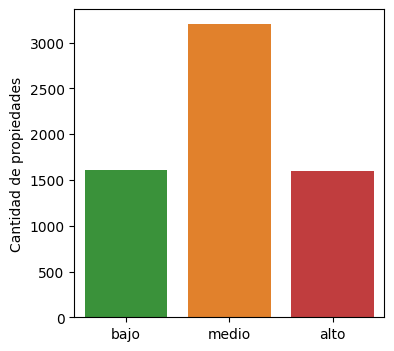

In [29]:
plt.figure(figsize=(4,4))
sns.barplot(data=ds_ph  , x=ds_ph.groupby(['pxm2_ph_intervalos_25p_50p_25p']).count().index.tolist() , y=ds_ph.groupby(['pxm2_ph_intervalos_25p_50p_25p']).count()['pxm2'].tolist() , palette = ['tab:green', 'tab:orange', 'tab:red']).set(ylabel='Cantidad de propiedades')
plt.show()

In [30]:
print("Los PHs con precios asignados como BAJOS (precio < %.2f) corresponden a 1/4 del total = %d" % (retbins_ph[1],ds_ph['pxm2_ph_intervalos_25p_50p_25p'].value_counts()['bajo']))
print("\nLos PHs con precios asignados como MEDIOS (%.2f < precio < %.2f) corresponden a 1/2 del total = %d" % (retbins_ph[1],retbins_ph[2],ds_ph['pxm2_ph_intervalos_25p_50p_25p'].value_counts()['medio']))
print("\nLos PHs con precios asignados como ALTOS (precio > %.2f) corresponden a 1/4 del total = %d" % (retbins_ph[2],ds_ph['pxm2_ph_intervalos_25p_50p_25p'].value_counts()['alto']))

Los PHs con precios asignados como BAJOS (precio < 1307.69) corresponden a 1/4 del total = 1605

Los PHs con precios asignados como MEDIOS (1307.69 < precio < 1976.88) corresponden a 1/2 del total = 3204

Los PHs con precios asignados como ALTOS (precio > 1976.88) corresponden a 1/4 del total = 1603


Y por ultimo analizamos las casas

In [31]:
ds_casa["pxm2_casa_intervalos_25p_50p_25p"], retbins_casa =pd.qcut(ds_casa["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4, retbins=True)
ds_casa["tipo_precio"]= ds_casa["pxm2_casa_intervalos_25p_50p_25p"].values

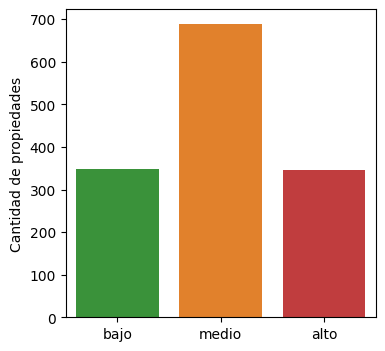

In [32]:
plt.figure(figsize=(4,4))
sns.barplot(data=ds_casa  ,x=ds_casa.groupby(['pxm2_casa_intervalos_25p_50p_25p']).count().index.tolist() , y=ds_casa.groupby(['pxm2_casa_intervalos_25p_50p_25p']).count()['pxm2'].tolist(), palette = ['tab:green', 'tab:orange', 'tab:red'] ).set(ylabel='Cantidad de propiedades')
plt.show()

In [33]:
print("Las casas con precios asignados como BAJOS (precio < %.2f) corresponden a 1/4 del total = %d" % (retbins_casa[1],ds_casa['pxm2_casa_intervalos_25p_50p_25p'].value_counts()['bajo']))
print("\nLas casas con precios asignados como MEDIOS (%.2f < precio < %.2f) corresponden a 1/2 del total = %d" % (retbins_casa[1],retbins_casa[2],ds_casa['pxm2_casa_intervalos_25p_50p_25p'].value_counts()['medio']))
print("\nLas casas con precios asignados como ALTOS (precio > %.2f) corresponden a 1/4 del total = %d" % (retbins_casa[2],ds_casa['pxm2_casa_intervalos_25p_50p_25p'].value_counts()['alto']))

Las casas con precios asignados como BAJOS (precio < 1254.63) corresponden a 1/4 del total = 348

Las casas con precios asignados como MEDIOS (1254.63 < precio < 1982.89) corresponden a 1/2 del total = 689

Las casas con precios asignados como ALTOS (precio > 1982.89) corresponden a 1/4 del total = 346


**Se decide utilizar la tercera opción para la clasificación, dado que consideramos adecuado que se tome un portentaje menor para las categorías de los extremos (precio bajo y precio alto).**

A su vez nos parece correcto que se analice dicha categorización distinguiendo según el tipo de propiedad, dado que puede variar lo que se considere un tipo de precio específico si se cambia el tipo de la propiedad. 

Tras haber decidido el ***criterio numero 3*** para clasificar `tipo_precio`, procedemos a juntar los valores recolectados en el analisis previo de dicho criterio (se guardaron en una columna `tipo_precio`, pero estan divididos en cada dataset auxiliar por tipo de propiedad)

In [34]:
properties_with_house_type_cond = x_train['property_type']  == 'Casa'
properties_with_PH_type_cond = x_train['property_type']  == 'PH'
properties_with_dept_type_cond = x_train['property_type']  == 'Departamento'

x_train.loc[properties_with_house_type_cond,'tipo_precio'] = ds_casa['tipo_precio'].values

x_train.loc[properties_with_PH_type_cond,'tipo_precio'] = ds_ph['tipo_precio'].values

x_train.loc[properties_with_dept_type_cond,'tipo_precio'] = ds_dpto['tipo_precio'].values


x_train_pca.loc[:,"tipo_precio"] = x_train["tipo_precio"].values 

In [35]:
# Elimino columnas que quedaron de analizar las otras opciones de criterios
x_train.drop(columns=['pxm2_intervalos_iguales', 'pxm2_intervalos_25p_50p_25p'], inplace=True)

Aplicamos a los datos de test los umbrales de precio obtenidos:

In [36]:
cond_casa_bajo = (x_test['property_type']  == 'Casa') & (x_test['pxm2'] <= retbins_casa[1])
cond_casa_medio = (x_test['property_type']  == 'Casa') & (x_test['pxm2'] > retbins_casa[1] ) & (x_test['pxm2'] <= retbins_casa[2])
cond_casa_alto = (x_test['property_type']  == 'Casa') & (x_test['pxm2'] > retbins_casa[2])

cond_ph_bajo = (x_test['property_type']  == 'PH') & (x_test['pxm2'] <= retbins_ph[1])
cond_ph_medio = (x_test['property_type']  == 'PH') & (x_test['pxm2'] > retbins_ph[1] ) & (x_test['pxm2'] <= retbins_ph[2])
cond_ph_alto = (x_test['property_type']  == 'PH') & (x_test['pxm2'] > retbins_ph[2])

cond_dpto_bajo = (x_test['property_type']  == 'Departamento') & (x_test['pxm2'] <= retbins_dpto[1])
cond_dpto_medio = (x_test['property_type']  == 'Departamento') & (x_test['pxm2'] > retbins_dpto[1] ) & (x_test['pxm2'] <= retbins_dpto[2])
cond_dpto_alto = (x_test['property_type']  == 'Departamento') & (x_test['pxm2'] > retbins_dpto[2])

# Aplicamos los umbrales
x_test.tipo_precio[cond_casa_bajo] = 'bajo'
x_test.tipo_precio[cond_casa_medio] = 'medio'
x_test.tipo_precio[cond_casa_alto] = 'alto'

x_test.tipo_precio[cond_ph_bajo] = 'bajo'
x_test.tipo_precio[cond_ph_medio] = 'medio'
x_test.tipo_precio[cond_ph_alto] = 'alto'

x_test.tipo_precio[cond_dpto_bajo] = 'bajo'
x_test.tipo_precio[cond_dpto_medio] = 'medio'
x_test.tipo_precio[cond_dpto_alto] = 'alto'


x_test_pca['tipo_precio'] = x_test['tipo_precio'].values

Asignamos los valores correspondientes a `y_train` e `y_test`.

Estaban vacíos dado que no se tenían los valores de la variable previo a decidir un criterio, pero se tiene el index de dichas `y_train` e `y_test` ya que fue dado en la separación 80/20.

(Primero nos aseguramos de que sean efectivamente los indices correctos para tener seguridad de que asignamos sin modificar el split, cabe destacar todo lo siguiente):

In [37]:
print(
    (x_train.index == y_train.index).all() and 
    (x_test.index == y_test.index).all() and
    (x_train_pca.index == y_train_pca.index).all() and
    (x_test_pca.index == y_test_pca.index).all() and
    (x_train.index == x_train_pca.index).all() and   #Gracias a esto (por random_state) es que podemos reeemplazar directamente por los mismos valores que obvtuvimos en el dataset original
    (x_test.index == x_test_pca.index).all() and
    (y_train.index == y_train_pca.index).all() and
    (y_test.index == y_test_pca.index).all()
) 

True


Con lo cual continuamos con las asignaciones

In [38]:
y_train = x_train.tipo_precio.copy()
y_test = x_test.tipo_precio.copy()

y_train_pca = x_train_pca.tipo_precio.copy()
y_test_pca = x_test_pca.tipo_precio.copy()

#### Visualizacion de propiedades con su tipo de precio geograficamente

Tras acabar con la division anterior, visualizamos los grupos en una mapa de CABA 

In [39]:
group1=x_train.loc[x_train["tipo_precio"]=="bajo"]
group2=x_train.loc[x_train["tipo_precio"]=="medio"]
group3=x_train.loc[x_train["tipo_precio"]=="alto"]

<Figure size 900x900 with 0 Axes>

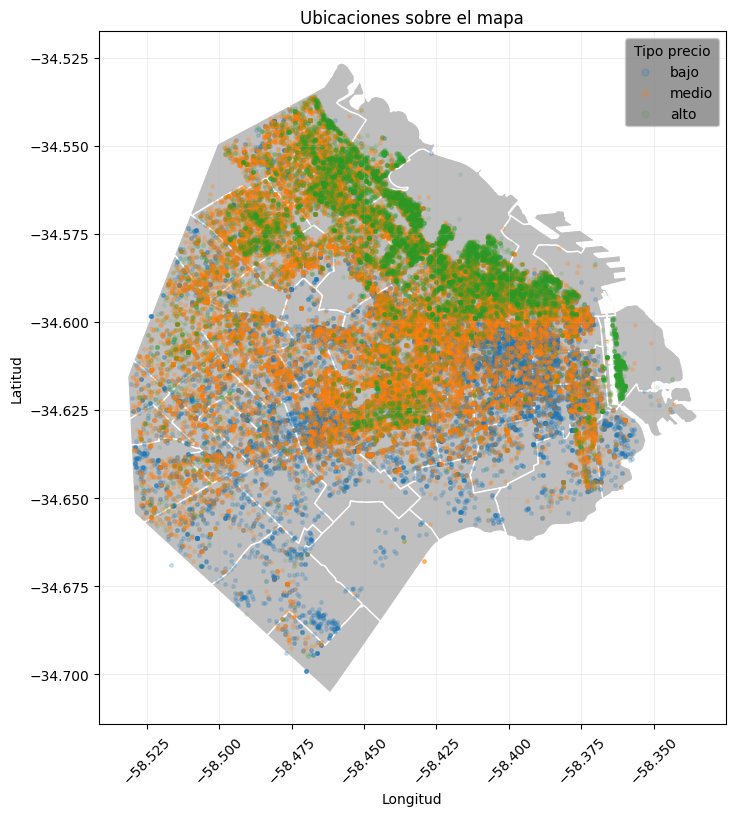

In [40]:
import geopandas as gpd

plt.figure(figsize=(9,9))

barrios = gpd.read_file('barrios.geojson')
p = gpd.GeoSeries(barrios.geometry)
p.plot(color='0.75', edgecolor='white', figsize=(9,9))

# graficamos los puntos
plt.scatter(x=group1.longitud,y=group1.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.', label='bajo')
plt.scatter(x=group2.longitud,y=group2.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.', label='medio')
plt.scatter(x=group3.longitud,y=group3.latitud ,s=25 ,cmap='viridis', alpha=0.1, marker='.', label='alto')

plt.legend(title='Tipo precio', markerscale=2, frameon=True, facecolor='0.5')
plt.title('Ubicaciones sobre el mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.tick_params(axis='x', labelrotation = 45)
plt.grid(alpha=0.2)
plt.show()

#### Comparación con clusters obtenidos anteriormente por KMeans

Como puede observarse, se puede afirmar que hay un grado considerable de similitud entre la segunda clusterización generada por el modelo de KMeans en la sección de Agrupamiento (notebook parte 2), la cuál tenía 3 grupos, de donde se había interpretado que el modelo realizó el agrupamiento a partir del crecimiento de los valores de las variables cuantitativas en general y con la ubicación por medio de las variables latitud y la longitud. 
Los grupos difieren un poco en cuanto a la ubicación precisa de los grupos de las observaciones (especificamente si se divide por cada localidad), pero tienen como principal parecido el "crecimiento" notable principalmente de suroccidente a nororiente.

## b) Entrenamiento y Predicción

Previo a entrenar los modelos debemos limpiar los datasets `x` de training que hayan quedado con variables directamente relacionadas al precio, ya que es la variable que se quiere predecir:

In [41]:
x_train.columns

Index(['latitud', 'property_rooms', 'property_type',
       'property_surface_covered', 'property_bedrooms', 'tipo_precio',
       'longitud', 'pxm2', 'property_surface_total'],
      dtype='object')

In [42]:
x_test.columns

Index(['latitud', 'property_rooms', 'property_type',
       'property_surface_covered', 'property_bedrooms', 'tipo_precio',
       'longitud', 'pxm2', 'property_surface_total'],
      dtype='object')

In [43]:
x_train_pca.columns

Index(['cp1', 'cp2', 'tipo_precio'], dtype='object')

In [44]:
x_test_pca.columns

Index(['cp1', 'cp2', 'tipo_precio'], dtype='object')

In [45]:
x_train.drop(columns=['pxm2', 'tipo_precio'], inplace=True)
x_test.drop(columns=['pxm2', 'tipo_precio'], inplace=True)

x_train_pca.drop(columns=['tipo_precio'], inplace=True)
x_test_pca.drop(columns=['tipo_precio'], inplace=True)

Ahora podemos continuar con los modelos.

### Modelo 1 : Árbol de decisión

Utilizamos una copia de los datos de train y test 

In [46]:
x_train_arbol = x_train.copy()
x_test_arbol = x_test.copy()
y_train_arbol = y_train.copy()
y_test_arbol = y_test.copy()

x_train_arbol_pca = x_train_pca.copy()
x_test_arbol_pca = x_test_pca.copy()
y_train_arbol_pca = y_train_pca.copy()
y_test_arbol_pca = y_test_pca.copy()

Procedemos a aplicar la ingenieria de features restante a los datsets de train y test:

Realizamos One Hot Encoding para el tipo de propiedad

In [47]:
x_train_arbol = pd.get_dummies(x_train_arbol, columns=['property_type'], drop_first=True)
x_test_arbol = pd.get_dummies(x_test_arbol, columns=['property_type'], drop_first=True)

nombres_cols = list(x_train_arbol) # nombres de features para uso posterior

Realizamos escalado MinMax

In [48]:
scaler = MinMaxScaler()
scaler.fit(x_train_arbol)
x_train_arbol = scaler.transform(x_train_arbol)
x_test_arbol = scaler.transform(x_test_arbol)

#### Buscamos optimizar hiperparametros con random search

In [49]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {
                'min_samples_split': list(range(2,15)),
                'ccp_alpha':np.linspace(0,0.05,n), 
                'max_depth':list(range(2,50)),
                'max_features': ['sqrt', None]
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = tree.DecisionTreeClassifier(random_state=29) 

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = 'accuracy',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=5) 

#Busco los hiperparametros que optimizan Accuracy Score
randomcv.fit(x_train_arbol, y_train_arbol);

#Mejor métrica
print(randomcv.best_score_)

0.669271631766577


#### Creamos el arbol, lo entrenamos y predecimos los valores de test

In [50]:
##Creamos un clasificador con hiperparámetros 
arbol = tree.DecisionTreeClassifier(random_state=2).set_params(**randomcv.best_params_)

#Entrenamos el modelo
arbol.fit(X = x_train_arbol, y = y_train_arbol)

#Realizamos una predicción sobre el set de test
y_pred_arbol = arbol.predict(x_test_arbol)

#### Graficamos el arbol generado (una porcion representativa)

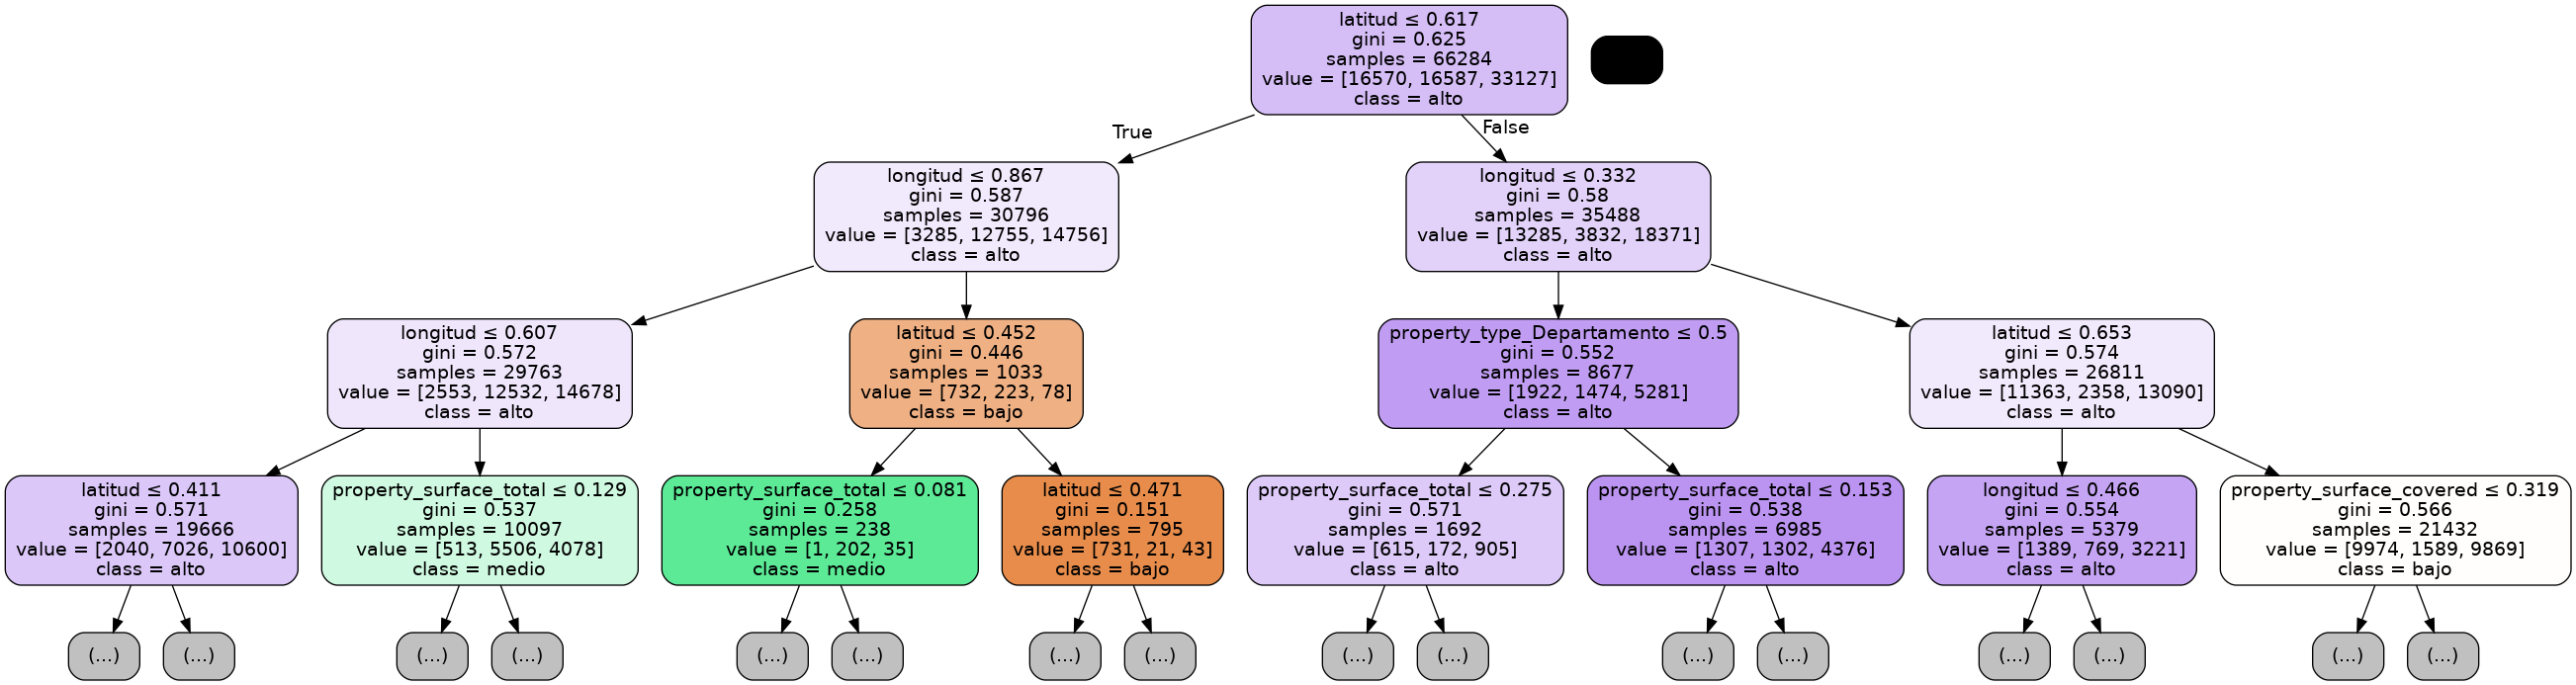

In [51]:
dot_data = StringIO()
export_graphviz(arbol,
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names= nombres_cols,
                class_names=categories,
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Analizamos distintos aspectos del árbol de decision entrenado

##### Analizamos cuales columnas fueron mas decisivas para las predicciones

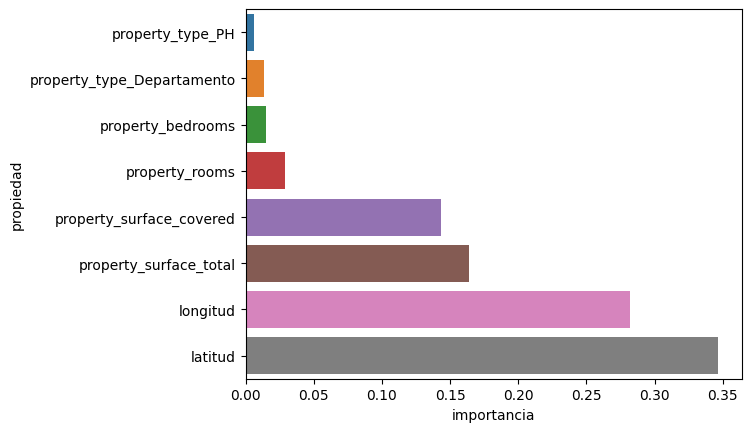

In [52]:
importancia_columna = pd.DataFrame(zip(nombres_cols, arbol.feature_importances_), columns=['propiedad','importancia'])
importancia_columna.sort_values(['importancia'], axis=0, inplace=True)

sns.barplot(y=importancia_columna['propiedad'], x=importancia_columna['importancia'])
plt.show()

##### Analizamos los parametros elegidos por random search para este arbol

In [53]:
for param, valor in randomcv.best_params_.items():
    print(f'{param} -> {valor}')

min_samples_split -> 7
max_features -> None
max_depth -> 41
ccp_alpha -> 0.0


##### Análisis del arbol y sus parametros

Tanto por la lista de importancia de los atributos como por lo visto en el árbol podemos ver que las siguientes propiedades son las que mas definen las predicciones:

* latitud
* longitud
* property_surface_total

Según estas propiedades, podemos pensar que lo que trata de hacer el árbol es ubicar la propiedad en el mapa, en primera instancia de norte a sur (latitud) y luego de este a oeste. Una vez hilado fino en estos aspectos, trata de diferenciar la propiedad según la superficie total.

En cuanto a los parametros podemos destacar las siguientes características:

* Se determinó que es mejor no realizar poda del árbol

* Se usan todos los features para entrenar

* En cuanto a la profundidad del árbol se estableció el límite en 41

* Para realizar una separación (decidir) la cantidad mínima de datos en el subconjunto deben ser 7

* Los demás parametros son los establecidos por defecto

    * Gini como criterio


#### Visualizamos las predicciones con un heatmap (la matriz de confusión)

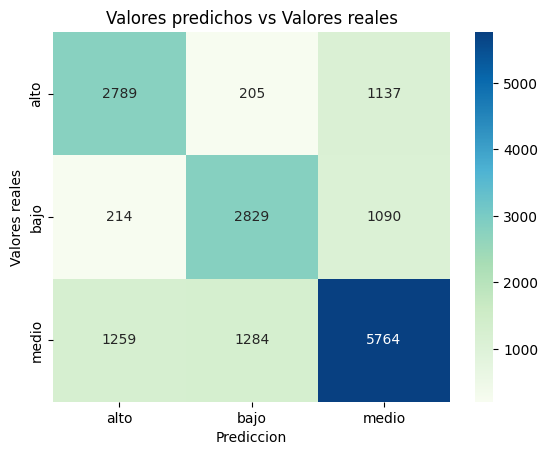

In [54]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test_arbol, y_pred_arbol)
labels = ['alto','bajo','medio']
#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Valores predichos vs Valores reales')
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.show()

#### Análisis de las métricas obtenidas

Métricas con datos de test

In [55]:
print(classification_report(y_test_arbol, y_pred_arbol))

              precision    recall  f1-score   support

        alto       0.65      0.68      0.66      4131
        bajo       0.66      0.68      0.67      4133
       medio       0.72      0.69      0.71      8307

    accuracy                           0.69     16571
   macro avg       0.68      0.68      0.68     16571
weighted avg       0.69      0.69      0.69     16571



Metricas con datos de train

In [56]:
print(classification_report(y_train_arbol, arbol.predict(x_train_arbol)))

              precision    recall  f1-score   support

        alto       0.88      0.92      0.90     16570
        bajo       0.90      0.91      0.90     16587
       medio       0.93      0.90      0.92     33127

    accuracy                           0.91     66284
   macro avg       0.90      0.91      0.91     66284
weighted avg       0.91      0.91      0.91     66284



Según el heatmap y la tabla de los resultados de las metricas podemos realizar las siguientes observaciones:

* Si restringimos la vision a alto y bajo, podemos notar que los diferencia bastante bien.

* Notamos que al árbol le cuesta encajar las relaciones bajo-medio y alto-medio, que puede tener sentido, a veces ese límite no es tan claro.

* Un poco menos de la mitad de las predicciones de alto y de bajo aterrizaron en la categoría medio.

* Y aproximadamente la mitad de los que en realidad son de tipo medio, se distribuyeron de forma casi equitativa entre alto y bajo.

* En cuanto a la comparación a las metricas con entre los datos de entrenamiento y los datos de test, observamos que con los datos de entrenamiento el accuracy es bastante más alto, un 20% mayor, lo cual tiene sentido porque son datos con los que se entrenó. De todas formas querriamos que sean lo mas parecidos posibles, tratando de subir la métrica para los datos de test.

#### Ahora repasamos el mismo procedimiento pero con el dataset generado con PCA

In [57]:
cols_pca = ['cp1', 'cp2']
# Estandarizamos

scaler = MinMaxScaler()
scaler.fit(x_train_arbol_pca)
x_train_arbol_pca = scaler.transform(x_train_arbol_pca)
x_test_arbol_pca = scaler.transform(x_test_arbol_pca)

#### Repetimos el proceso de Random Search para este dataset

In [58]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_pca_grid = {
                'min_samples_split': list(range(2,15)),
                'ccp_alpha':np.linspace(0,0.05,10*n), 
                'max_depth':list(range(2,50)),
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = tree.DecisionTreeClassifier(random_state=231) 

#Random Search Cross Validation
randomcv_pca = RandomizedSearchCV(estimator = base_tree,
                                    param_distributions = params_pca_grid,
                                    scoring = 'accuracy',
                                    cv = kfoldcv,
                                    n_jobs = -1,
                                    n_iter = n,
                                    random_state=113) 

#Busco los hiperparametros que optimizan Accuracy Score
randomcv_pca.fit(x_train_arbol_pca, y_train_arbol_pca);

#Mejor métrica
print(randomcv_pca.best_score_)

0.5287701788727186


#### Entrenamos y visualizamos el nuevo árbol (con poda)

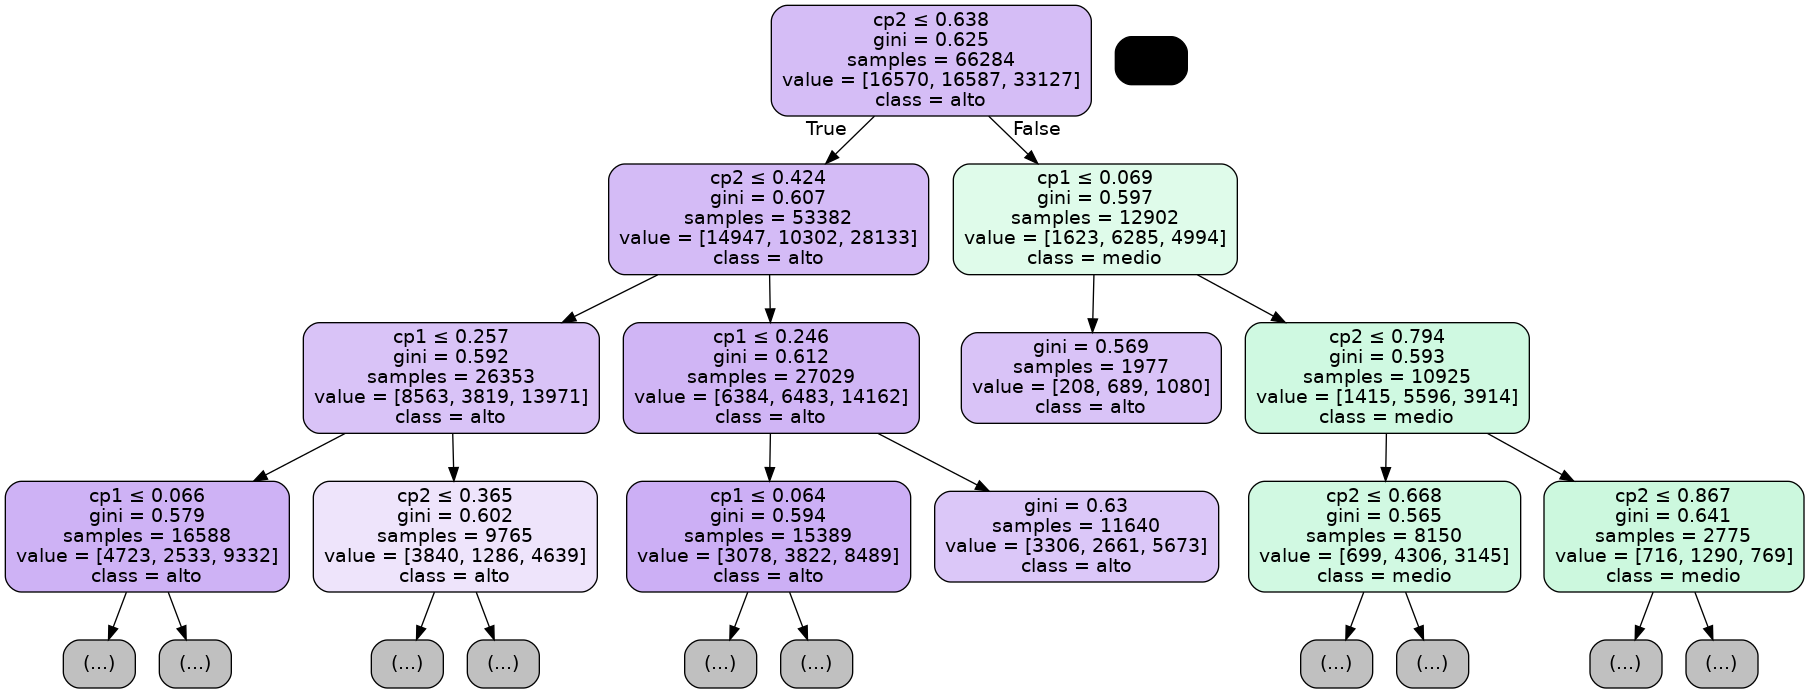

In [59]:
##Creamos un clasificador con hiperparámetros 
arbol_pca = tree.DecisionTreeClassifier(random_state=2).set_params(**randomcv_pca.best_params_)

#Entrenamos el modelo
arbol_pca.fit(X = x_train_arbol_pca, y = y_train_arbol_pca)

#Realizamos una predicción sobre el set de test
y_pred_arbol_pca = arbol_pca.predict(x_test_arbol_pca)

dot_data = StringIO()
export_graphviz(arbol_pca,
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=cols_pca,
                class_names=categories,
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Repasamos los parametros que resultaron de Random Search

El ánalisis de cada uno está explicado en la sección anterior, cuando fue entrenado con el dataset sin reducción de la dimensionalidad

In [60]:
for param, valor in randomcv_pca.best_params_.items():
    print(f'{param} -> {valor}')

min_samples_split -> 13
max_depth -> 14
ccp_alpha -> 0.000505050505050505


#### Visualizamos las predicciones realizadas en la matriz de confusión

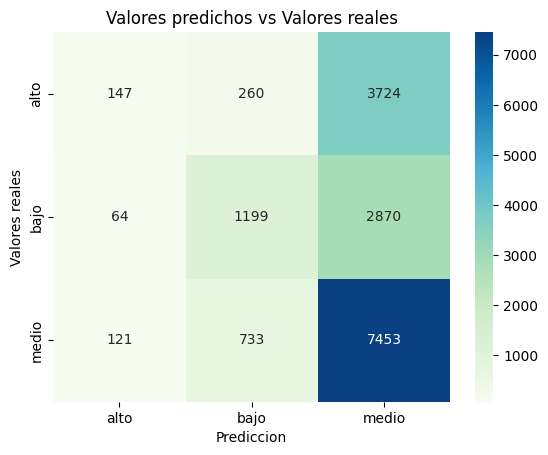

In [61]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test_arbol_pca, y_pred_arbol_pca)

labels = ['alto','bajo','medio']
#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Valores predichos vs Valores reales')
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.show()

#### Comparamos las métricas

Con datos de test

In [62]:
print(classification_report(y_test_arbol_pca,y_pred_arbol_pca))

              precision    recall  f1-score   support

        alto       0.44      0.04      0.07      4131
        bajo       0.55      0.29      0.38      4133
       medio       0.53      0.90      0.67      8307

    accuracy                           0.53     16571
   macro avg       0.51      0.41      0.37     16571
weighted avg       0.51      0.53      0.45     16571



Con datos de entrenamiento

In [63]:
print(classification_report(y_train_arbol_pca, arbol_pca.predict(x_train_arbol_pca)))

              precision    recall  f1-score   support

        alto       0.43      0.04      0.07     16570
        bajo       0.55      0.28      0.37     16587
       medio       0.53      0.90      0.67     33127

    accuracy                           0.53     66284
   macro avg       0.50      0.41      0.37     66284
weighted avg       0.51      0.53      0.44     66284



Para este caso la performance es bastante mejor para los datos de entrenamiento.

#### Comparación entre ambos árboles

En este apartado vamos a comparar los resultados obtenidos de un mismo tipo de clasificador entrenado con dos datasets distintos para predecir los mismos resultados.

Por un lado tenemos un dataset con muchas propiedades y por el otro el resultado de una reducción de la dimensionalidad (a 2 dimensiones) de éste último.

La idea es contrastar resultados y ver si nos conviene entrenar nuestro modelo con un dataset más reducido, sacrificando probablemente un poco de la performance del modelo.

Dando un vistazo por encima, encontramos que ambos modelos tienen ciertas caracteristicas en común a la hora de predecir. Si miramos ambos heatmaps notaremos que tienen la misma estructura:

* Diferencia bien entre altos y bajos, pero confunde ambos con los medios

A pesar de que ambos se comportan de forma similar, cuando obtenemos los mejores resultados de ambos modelos notamos que el entrenado con el dataset original supera por 0.15 en accuracy (métrica principal observada para ambos modelos) al modelo entrenado con el dataset de dimensión reducida.

Consideramos que la brecha es lo suficientemente grande como para rechazar éste último y quedarnos con el primer modelo.

#### Exportamos los modelos entrenados

In [64]:
joblib.dump(arbol, 'clasificador_arbolDecision.joblib')
joblib.dump(arbol_pca, 'clasificador_arbolDecisionPCA.joblib')

['clasificador_arbolDecisionPCA.joblib']

### Modelo 2: Random Forest

Utilizamos una copia de los datos de train y test

In [65]:
x_train_rforest = x_train.copy()
x_test_rforest = x_test.copy()
y_train_rforest = y_train.copy()
y_test_rforest = y_test.copy()

x_train_rforest_pca = x_train_pca.copy()
x_test_rforest_pca = x_test_pca.copy()
y_train_rforest_pca = y_train_pca.copy()
y_test_rforest_pca = y_test_pca.copy()

Continuamos aplicando la ingenieria de features restante a los datsets de train y test:

Realizamos One Hot Encoding nuevamente para el tipo de propiedad

In [66]:
x_train_rforest = pd.get_dummies(x_train_rforest, columns=['property_type'], drop_first=True)
x_test_rforest = pd.get_dummies(x_test_rforest, columns=['property_type'], drop_first=True)

nombres_cols = list(x_train_rforest) # nombres de features para uso posterior

Realizamos el escalado MinMax

In [67]:
scaler = MinMaxScaler()
scaler.fit(x_train_rforest)
x_train_rforest = scaler.transform(x_train_rforest)
x_test_rforest = scaler.transform(x_test_rforest)

#### Buscamos optimizar hiperparametros con random search

In [68]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=5

#Conjunto de parámetros que quiero usar
params_grid = {
                'n_estimators':      list(range(10,161,10)),
                'min_samples_split': list(range(2,15)),
                'ccp_alpha':         np.linspace(0,0.05,n), 
                'max_depth':         list(range(2,25)),
                'max_samples':       np.linspace(0.5,1,n)
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
forest = RandomForestClassifier(random_state=231) 

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = forest,
                              param_distributions = params_grid,
                              scoring = 'accuracy',
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n,
                              random_state=231) 

#Busco los hiperparamtros que optimizan Accuracy Score
randomcv.fit(x_train_rforest, y_train_rforest)

#Mejor métrica
print(randomcv.best_score_)

0.7099299369244992


#### Creamos el random forest, lo entrenamos y predecimos los valores de test

In [69]:
##Creamos un clasificador con hiperparámetros 
forest = RandomForestClassifier(random_state=231).set_params(**randomcv.best_params_)

#Entrenamos el modelo
forest.fit(X = x_train_rforest, y = y_train_rforest)

#Realizamos una predicción sobre el set de test
y_pred_rforest = forest.predict(x_test_rforest)

#### Graficamos uno de los arboles generados (una porcion representativa)

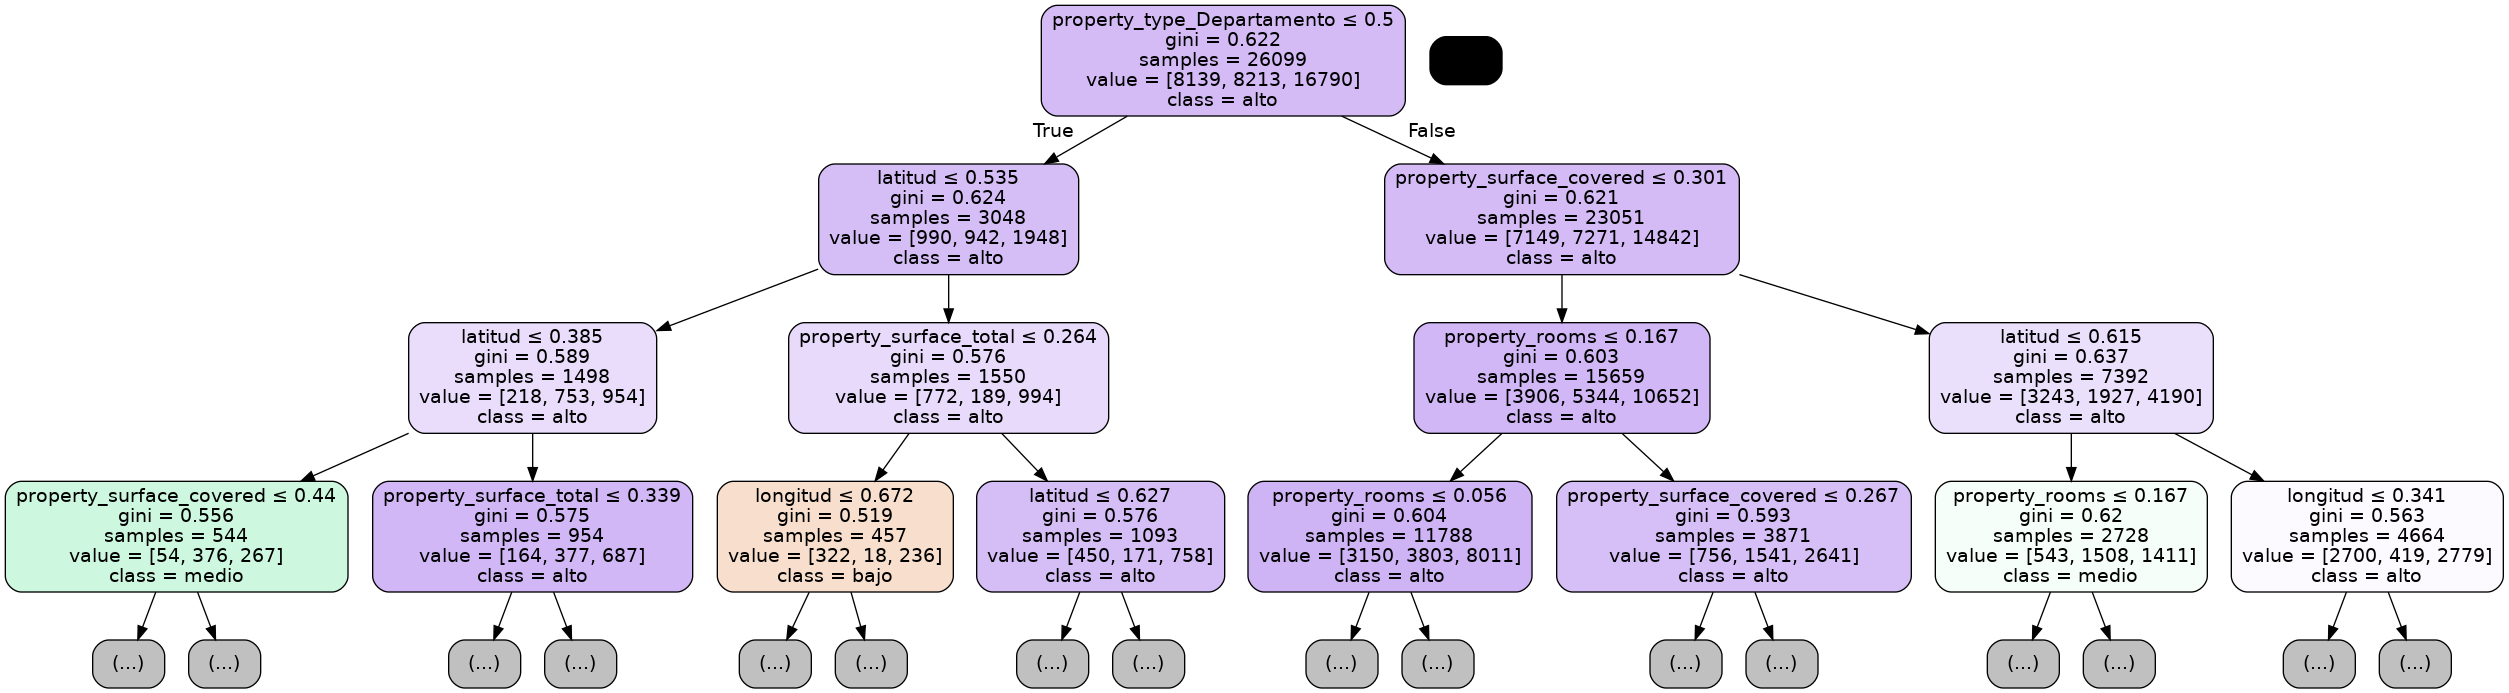

In [70]:
dot_data = StringIO()

export_graphviz(forest.estimators_[0],
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=nombres_cols,
                class_names=categories,
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Analizamos distintos aspectos del modelo entrenado

##### Analizamos cuales columnas fueron mas decisivas para las predicciones

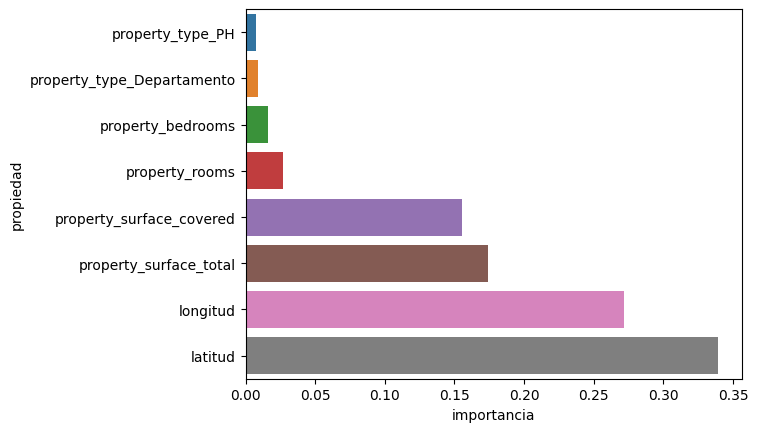

In [71]:
importancia_columna = pd.DataFrame(zip(nombres_cols, forest.feature_importances_), columns=['propiedad','importancia'])
importancia_columna.sort_values(['importancia'], axis=0, inplace=True)

sns.barplot(y=importancia_columna['propiedad'], x=importancia_columna['importancia'])
plt.show()

##### Analizamos los parametros elegidos por random search para este forest

In [72]:
for param, valor in randomcv.best_params_.items():
    print(f'{param} -> {valor}')

n_estimators -> 100
min_samples_split -> 8
max_samples -> 0.5
max_depth -> 24
ccp_alpha -> 0.0


#### Análisis del arbol y sus parametros

Tanto por la lista de importancia de los atributos como por lo visto en el árbol podemos ver que las siguientes propiedades son las que mas definen las predicciones:

* latitud
* longitud
* property_surface_total

Según estas propiedades, podemos pensar que lo que trata de hacer el árbol es ubicar la propiedad en el mapa, en primera instancia de norte a sur (latitud) y luego de este a oeste. Una vez hilado fino en estos aspectos, trata de diferenciar la propiedad según la superficie total.


En cuanto a los parametros podemos destacar las siguientes características, determinadas por random search y análisis de resultados empiricos:

* La cantidad de estimadores utilizados por el modelo de random forest es 100

* Para realizar una separación (decidir) la cantidad mínima de datos en el subconjunto deben ser 8 

* En cuanto a Bootstrap, el tamaño de las muestras utilizadas en cada instancia es 0.5 del total

* La profundidad de los arboles no supera 24 niveles

* Y por último, random search nos propone como mejor opción en esta ocasión no realizar poda posterior

* Los demás parametros son los establecidos por defecto
    * Utilizando Bootstrap
    * La cantidad de features aleatorios para cada arbol entrenado es 'sqrt' del total
    * Criterio de decisión 'gini'

#### Visualizamos los resultados de la predicción en la matriz de confusión

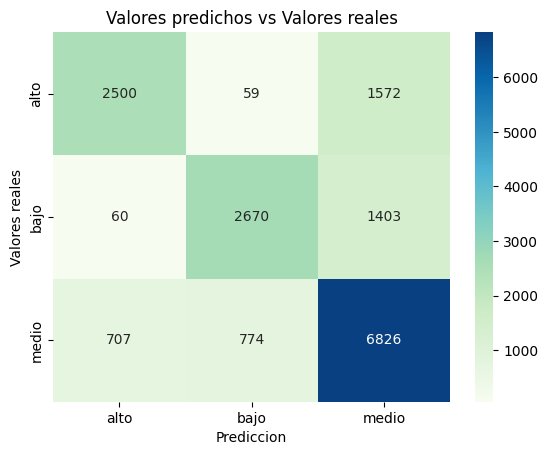

In [73]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test_rforest, y_pred_rforest)
labels = ['alto','bajo','medio']
#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Valores predichos vs Valores reales')
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.show()

#### Análisis de las métricas obtenidas

Con datos de test

In [74]:
print(classification_report(y_test_rforest, y_pred_rforest))

              precision    recall  f1-score   support

        alto       0.77      0.61      0.68      4131
        bajo       0.76      0.65      0.70      4133
       medio       0.70      0.82      0.75      8307

    accuracy                           0.72     16571
   macro avg       0.74      0.69      0.71     16571
weighted avg       0.73      0.72      0.72     16571



Con datos de train

In [75]:
print(classification_report(y_train_rforest,forest.predict(x_train_rforest)))

              precision    recall  f1-score   support

        alto       0.91      0.77      0.83     16570
        bajo       0.90      0.79      0.84     16587
       medio       0.82      0.93      0.87     33127

    accuracy                           0.85     66284
   macro avg       0.87      0.83      0.85     66284
weighted avg       0.86      0.85      0.85     66284



Según el heatmap y la tabla de los resultados de las metricas podemos realizar las siguientes observaciones:

* Si restringimos la vision a alto y bajo, podemos notar que los diferencia bastante bien.

* Notamos que al árbol le cuesta un poco mas encajar las relaciones bajo-medio y alto-medio, que puede tener sentido, a veces ese límite no es tan claro.

    * Es mas grande la confusión del modelo al predecir 'medio' cuando en realidad es una de las otras dos opciones

* En cuanto a la comparación a las metricas con los datos de tests, los resultados no son tan buenos como en train, pero consideramos que un accuracy de 0.72 está bastante bien en comparación a otros modelos entrenados.

#### Ahora repasamos el mismo procedimiento pero con el dataset generado con PCA

Escalado nuevamente

In [76]:
# Estandarizamos
scaler = MinMaxScaler()
scaler.fit(x_train_rforest_pca)
x_train_rforest_pca = scaler.transform(x_train_rforest_pca)
x_test_rforest_pca = scaler.transform(x_test_rforest_pca)

#### Repetimos el proceso de Random Search para este dataset

In [77]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=5

#Conjunto de parámetros que quiero usar
params_pca_grid = {
                'n_estimators':      list(range(10,161,10)),
                'min_samples_split': list(range(2,15)),
                'ccp_alpha':         np.linspace(0,0.05,n), 
                'max_depth':         list(range(2,25)),
                'max_samples':       np.linspace(0.5,1,n)
              }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
forest = RandomForestClassifier(random_state=231, max_features=None)

#Random Search Cross Validation
randomcv_pca = RandomizedSearchCV(estimator = forest,
                                    param_distributions = params_pca_grid,
                                    scoring = 'accuracy',
                                    cv = kfoldcv,
                                    n_jobs = -1,
                                    n_iter = n,
                                    random_state=231) 

#Busco los hiperparamtros que optimizan Accuracy Score
randomcv_pca.fit(x_train_rforest_pca, y_train_rforest_pca);

#Mejor métrica
print(randomcv_pca.best_score_)

0.6024530088498354


#### Entrenamos. Luego visualizamos un árbol

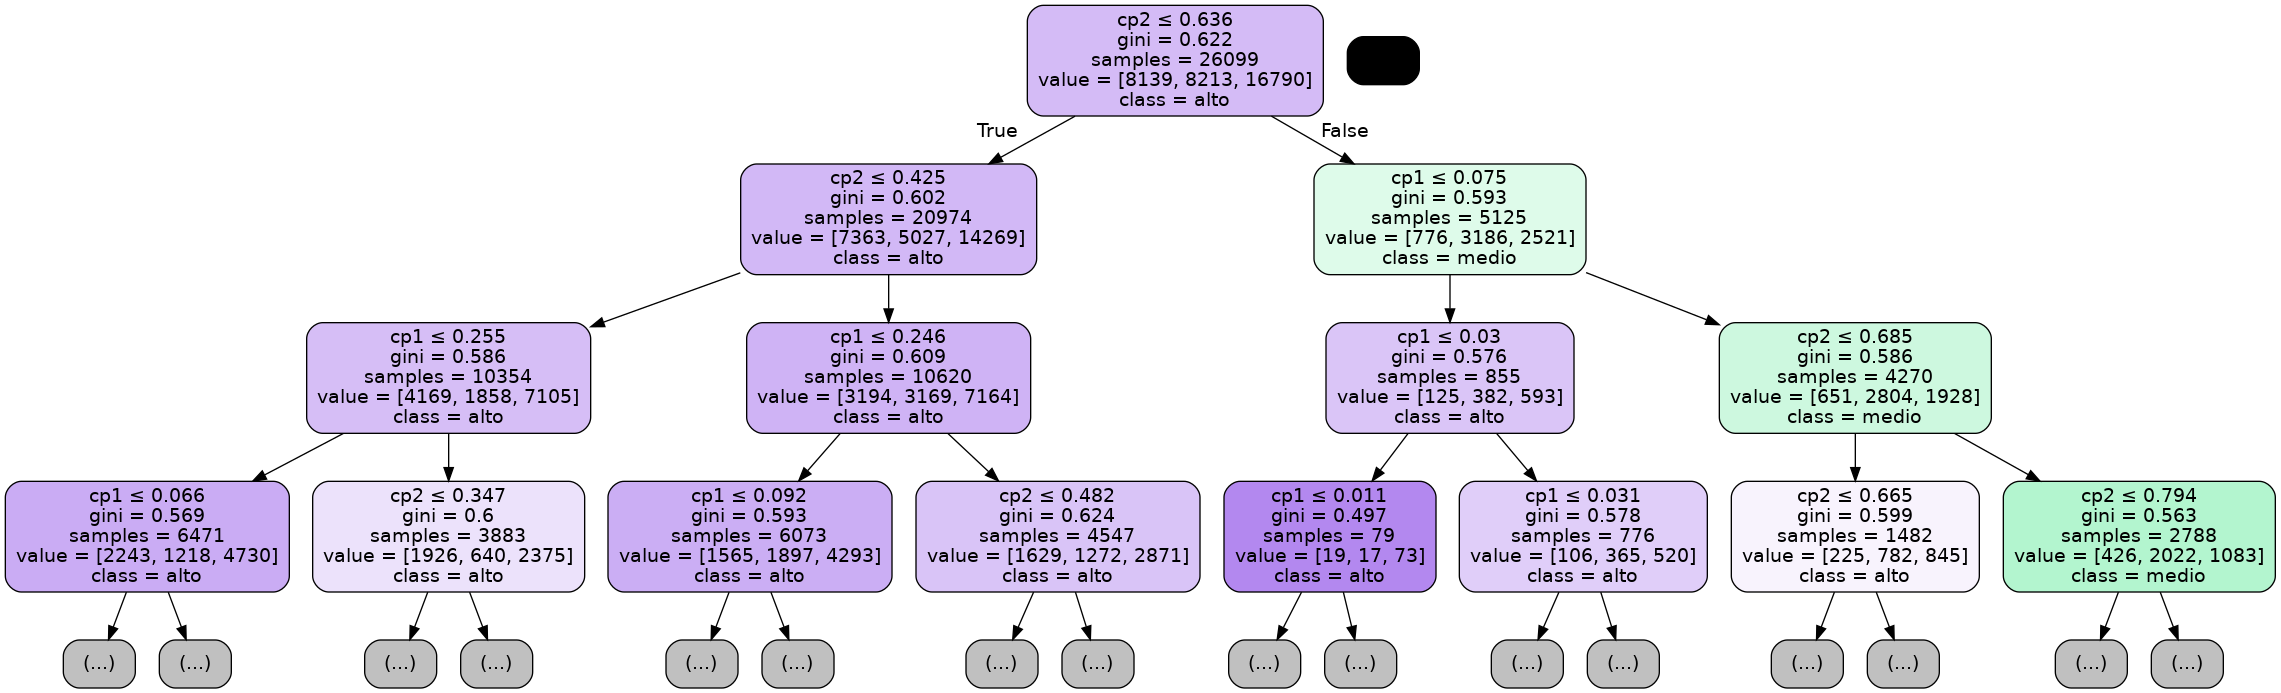

In [78]:
##Creamos un clasificador con hiperparámetros 
forest_pca = RandomForestClassifier(random_state=231, max_features=None).set_params(**randomcv_pca.best_params_)

#Entrenamos el modelo
forest_pca.fit(X = x_train_rforest_pca, y = y_train_rforest_pca)

#Realizamos una predicción sobre el set de test
y_pred_rforest_pca = forest_pca.predict(x_test_rforest_pca)

dot_data = StringIO()
export_graphviz(forest_pca.estimators_[0],
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=cols_pca,
                class_names=categories,
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Repasamos los parametros que resultaron de Random Search

El ánalisis de cada uno está explicado en la sección anterior, cuando fue entrenado con el dataset sin reducción de la dimensionalidad

In [79]:
for param, valor in randomcv_pca.best_params_.items():
    print(f'{param} -> {valor}')

n_estimators -> 100
min_samples_split -> 8
max_samples -> 0.5
max_depth -> 24
ccp_alpha -> 0.0


#### Visualizamos las predicciones realizadas en la matriz de confusión

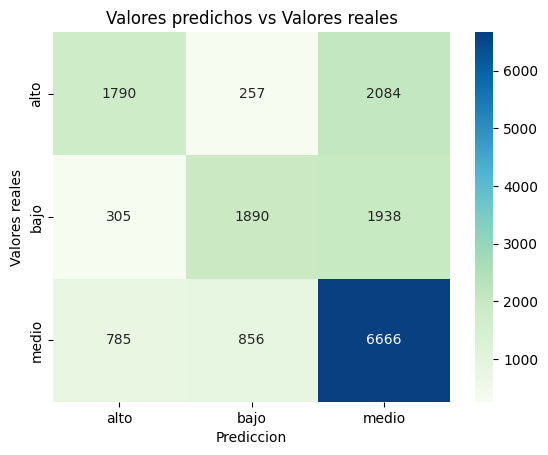

In [80]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test_rforest_pca, y_pred_rforest_pca)

labels = ['alto','bajo','medio']

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Valores predichos vs Valores reales')
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.show()

#### Comparamos las métricas

Con datos de test

In [81]:
print(classification_report(y_test_rforest_pca,y_pred_rforest_pca))

              precision    recall  f1-score   support

        alto       0.62      0.43      0.51      4131
        bajo       0.63      0.46      0.53      4133
       medio       0.62      0.80      0.70      8307

    accuracy                           0.62     16571
   macro avg       0.62      0.56      0.58     16571
weighted avg       0.62      0.62      0.61     16571



Con datos de entrenamiento

In [82]:
print(classification_report(y_train_rforest_pca, forest_pca.predict(x_train_rforest_pca)))

              precision    recall  f1-score   support

        alto       0.86      0.65      0.74     16570
        bajo       0.84      0.64      0.73     16587
       medio       0.75      0.93      0.83     33127

    accuracy                           0.79     66284
   macro avg       0.82      0.74      0.77     66284
weighted avg       0.80      0.79      0.78     66284



Observamos que se deteriora bastante el desempeño del modelo siendo aplicado al dataset pca, tiende a clasificar demasiados valores como de categoria media.

#### Exportamos los modelos entrenados

In [83]:
joblib.dump(forest, 'clasificador_randomForest.joblib')
joblib.dump(forest_pca, 'clasificador_randomForest_PCA.joblib')

['clasificador_randomForest_PCA.joblib']

### Modelo 3: KNN


Se optó por este modelo como el tercero a utilizar para observar sus resultados de categorización dado que:
- Se puede utilizar para clasificación(o regresión).
- Su idea se basa en el hecho de que los puntos de datos similares estarán más cerca en el espacio que los puntos que son muy diferentes entre sí.

Utilizamos una copia de los datos de train y test

In [84]:
x_train_knn = x_train.copy()
x_test_knn = x_test.copy()
y_train_knn = y_train.copy()
y_test_knn = y_test.copy()

x_train_knn_pca = x_train_pca.copy()
x_test_knn_pca = x_test_pca.copy()
y_train_knn_pca = y_train_pca.copy()
y_test_knn_pca = y_test_pca.copy()

Continuamos aplicando la ingenieria de features restante a los datsets de train y test:

Realizamos One Hot Encoding nuevamente para el tipo de propiedad

In [85]:
x_train_knn = pd.get_dummies(x_train_knn, columns=['property_type'], drop_first=True)
x_test_knn = pd.get_dummies(x_test_knn, columns=['property_type'], drop_first=True)

nombres_cols = list(x_train_knn) # nombres de features para uso posterior

Realizamos el escalado MinMax para que las variables tengan el mismo peso

In [86]:
scaler = MinMaxScaler()
scaler.fit(x_train_knn)
x_train_knn = scaler.transform(x_train_knn)
x_test_knn = scaler.transform(x_test_knn)

#### Aproximacion inicial a la cantidad de vecinos del modelo

Para poder tener un primer vistazo de la cantidad de vecinos del modelo, se entrenan distintos de los mismos que tomaran una cantidad incremental de vecinos para calcular las distancias.

Asi se podra observar gráficamente cuál puede llegar a ser un valor tentativo, que posteriormente va a ser corroborado o descartado al utilizar RandomSearchCV.

In [87]:
# Variamos la cantidad de vecinos (K)

metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 14) # vecinos desde 1 hasta cantidad total de puntos en test

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train_knn, y_train_knn)
    y_pred_knn = knn.predict(x_test_knn)
    metrics.append((n, (y_test_knn == y_pred_knn).sum()))

Graficamos la relación entre precisión y número de vecinos.

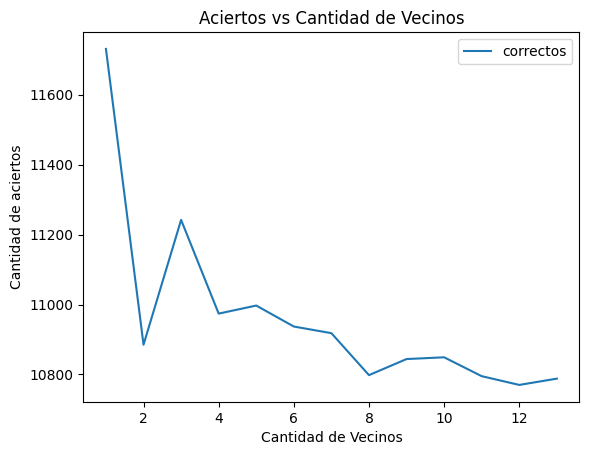

In [88]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Ahora probamos esta misma variación haciendo uso de Cross-Validation

In [89]:
from sklearn.model_selection import cross_val_score

k_range=range(1,14) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train_knn, y_train_knn, cv=10,scoring='accuracy')
    #promedio las 10 métricas
    k_scores.append(scores.mean())

Graficamos accuracy vs cantidad de vecinos

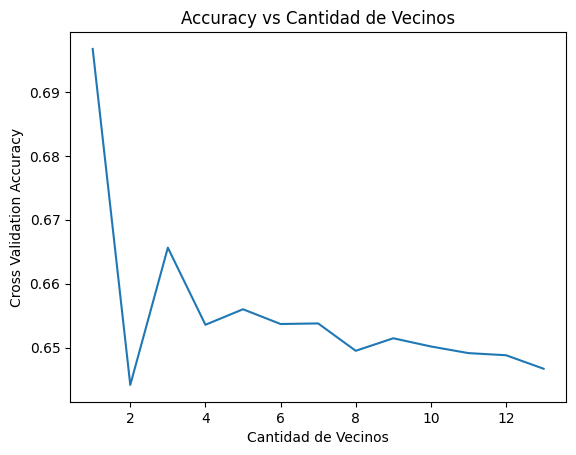

In [90]:
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('Accuracy vs Cantidad de Vecinos')
plt.show()

Podemos observar que hay una tendencia a que la performance descienda a medida que que se aumenta la cantidad de vecinos. Salvo en el caso donde hay 3 vecinos.

#### Optimizacion de Hiperparametros por medio de Random Search 

Entre parametros que podemos utilizar, se tienen:
- n_neighbors: número de vecinos a considerar, por defecto este valor esta seteado en 5.
- algorithm:algoritmo utilizado para calcular los vecinos más cercanos
    - ball_tree utilizará BallTree
    - kd_tree : utilizará KDTree
    - brute : utilizará una búsqueda de fuerza bruta.
- metric: métrica a utilizar para el cálculo de la distancia. El valor predeterminado es "minkowski". Las métricas válidas dependerán del algorítmo que utilicemos.
    - eculidea
    - manhattan
    - city block
- weights:función de peso utilizada en la predicción
    - uniform : pesos uniformes, todos los puntos en cada "vecindario" pesan lo mismo.
    - distance : el peso de cada punto (vecino) se asigna en forma inversa a su distancia.

Primero vemos las distancias admitidas por cada algoritmo


In [91]:
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

#Métricas Válidas
VALID_METRICS = dict(
    ball_tree=BallTree.valid_metrics,
    kd_tree=KDTree.valid_metrics,
    # The following list comes from the sklearn.metrics.pairwise doc string
    brute=list(PAIRWISE_DISTANCE_FUNCTIONS.keys())
    + [ 'braycurtis','canberra','chebyshev','correlation',
        'cosine','dice','hamming','jaccard','kulsinski',
        'mahalanobis','matching','minkowski','rogerstanimoto',
        'russellrao','seuclidean','sokalmichener','sokalsneath',
        'sqeuclidean','yule','wminkowski',
    ],
)

#Ejemplo
for alg in VALID_METRICS:
    print(f'algoritmo: {alg}')
    print(VALID_METRICS[alg])
    print()

algoritmo: ball_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'pyfunc']

algoritmo: kd_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity']

algoritmo: brute
['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski']



Teniendo todo esto en cuenta aplicamos random search cross validation

In [92]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,4), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

rand.fit(x_train_knn, y_train_knn)
rand.cv_results_['mean_test_score']

array([0.66243737, 0.70564566, 0.69479833, 0.64415262, 0.69906795,
       0.6393701 , 0.66189429, 0.66563583, 0.70137616, 0.70940221])

In [93]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan', 'algorithm': 'brute'}
0.7094022074145598


El valor de la cantidad de vecinos fue optimizada en 3 lo cual coincide con las observaciones que habiamos hecho previamente.

#### Predecimos los valores de test con el modelo optimizado

In [94]:
#Mejor estimador
best_knn = rand.best_estimator_

#Predicción con mejor estimador
y_pred_knn=best_knn.predict(x_test_knn)


#Accuracy test
accuracy_score(y_test_knn,y_pred_knn)

0.7205358759278258

#### Procedemos a visualizar la matriz de confusión

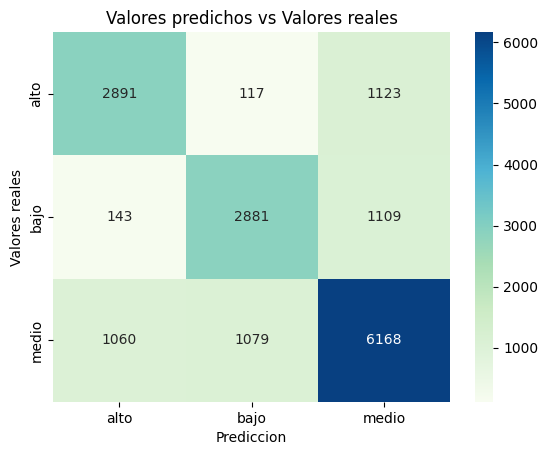

In [95]:
#Matriz de Confusión
cm = confusion_matrix(y_test_knn,y_pred_knn)
labels = ['alto','bajo','medio']
sns.heatmap(cm,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.title('Valores predichos vs Valores reales')

plt.show()

#### Análisis de las métricas obtenidas

Con datos de test

In [96]:
#Reporte de Clasificación
print(classification_report(y_test_knn ,y_pred_knn))

              precision    recall  f1-score   support

        alto       0.71      0.70      0.70      4131
        bajo       0.71      0.70      0.70      4133
       medio       0.73      0.74      0.74      8307

    accuracy                           0.72     16571
   macro avg       0.72      0.71      0.71     16571
weighted avg       0.72      0.72      0.72     16571



Con datos de train

In [97]:
print(classification_report(y_train_knn, best_knn.predict(x_train_knn)))

              precision    recall  f1-score   support

        alto       0.97      0.98      0.97     16570
        bajo       0.97      0.98      0.97     16587
       medio       0.98      0.97      0.97     33127

    accuracy                           0.97     66284
   macro avg       0.97      0.98      0.97     66284
weighted avg       0.97      0.97      0.97     66284



Según el heatmap y la tabla de los resultados de las metricas podemos realizar las siguientes observaciones:

* Diferencia bastante bien si se restringe nuevamente a observar la categoria alta y baja, aunque con más False Positives que en los demás modelos.

* Notamos que nuevamente al modelo le cuesta más predecir las observaciones que oscilan entre bajo-medio y alto-medio.

* En cuanto a la comparación a las metricas con los datos de tests, se puede notar que puede haber un leve caso de overfitting si se predice sobre los datos de training, lo cual es de esperar por como funciona el modelo. Sin embargo al aplicar a los datos de test se tiene una accuracy de 0.72, lo cual sigue siendo muy positivo. 

#### Repasamos el mismo procedimiento pero con el dataset generado con PCA

Escalado nuevamente

In [98]:
scaler = MinMaxScaler()
scaler.fit(x_train_knn_pca)
x_train_knn_pca = scaler.transform(x_train_knn_pca)
x_test_knn_pca = scaler.transform(x_test_knn_pca)

#### Repetimos el proceso de Random Search para este dataset

In [99]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,4), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

rand.fit(x_train_knn_pca, y_train_knn_pca)
rand.cv_results_['mean_test_score']

array([0.56285084, 0.61794747, 0.60967988, 0.54175998, 0.61043423,
       0.53930087, 0.56285084, 0.56457085, 0.61369294, 0.61894317])

In [100]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan', 'algorithm': 'brute'}
0.6189431748340101


#### Predecimos los valores de test con el modelo optimizado

In [101]:
#Mejor estimador
best_knn_pca=rand.best_estimator_

#Predicción con mejor estimador
y_pred_knn_pca = best_knn_pca.predict(x_test_knn_pca)


#Accuracy test
accuracy_score(y_test_knn_pca,y_pred_knn_pca)

0.6314042604550117

#### Procedemos a visualizar la matriz de confusión

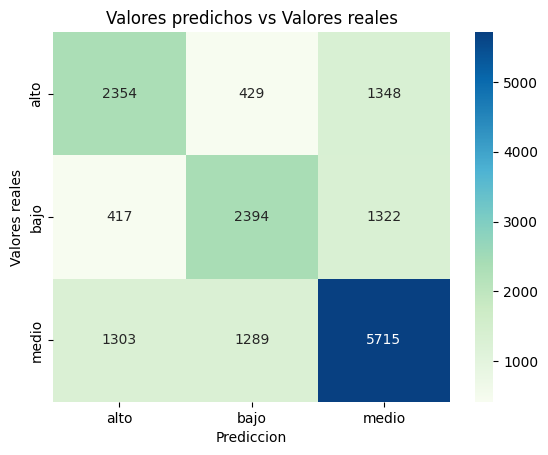

In [102]:
#Matriz de Confusión
cm = confusion_matrix(y_test_knn_pca,y_pred_knn_pca)
labels = ['alto','bajo','medio']
sns.heatmap(cm,cmap='GnBu',annot=True,fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.title('Valores predichos vs Valores reales')
plt.show()

#### Análisis de las métricas obtenidas

Con datos de test

In [103]:
#Reporte de Clasificación
print(classification_report(y_test_knn_pca ,y_pred_knn_pca))

              precision    recall  f1-score   support

        alto       0.58      0.57      0.57      4131
        bajo       0.58      0.58      0.58      4133
       medio       0.68      0.69      0.68      8307

    accuracy                           0.63     16571
   macro avg       0.61      0.61      0.61     16571
weighted avg       0.63      0.63      0.63     16571



Con datos de train

In [104]:
print(classification_report(y_train_knn_pca, best_knn_pca.predict(x_train_knn_pca)))

              precision    recall  f1-score   support

        alto       0.96      0.98      0.97     16570
        bajo       0.96      0.98      0.97     16587
       medio       0.98      0.96      0.97     33127

    accuracy                           0.97     66284
   macro avg       0.97      0.97      0.97     66284
weighted avg       0.97      0.97      0.97     66284



A pesar de que la matriz de confusión muestra resultados bastante similares a la correspondiente al dataset original, se vuelve a observar el overfitting marcado sobre la predicción en los datos de train, pero además se deterioró mucho más el resultado de la predicción sobre los datos de tests, con lo cual para este modelo no conviene utilizar el dataset redimensionado con PCA.

#### Exportamos los modelos entrenados

In [105]:
joblib.dump(best_knn, 'clasificador_knn.joblib')
joblib.dump(best_knn_pca, 'clasificador_knn_PCA.joblib')

['clasificador_knn_PCA.joblib']

### Elección de modelo 




Recompilando los resultados obtenidos en la accuracy de los modelos tenemos:
- Arbol de decisión:
    - Accuracy para dataset original = test:  0.69 / train:  0.91
    - Accuracy para dataset con pca = test:  0.53 / train:  0.53
- RandomForest
    - Accuracy para dataset original = test:  0.72 / train:  0.85
    - Accuracy para dataset con pca = test:  0.62 / train:  0.79
- KNN
    - Accuracy para dataset original = test:  0.72 / train:  0.97
    - Accuracy para dataset con pca = test:  0.63 / train:  0.97

Entre los modelos, los más destacados fueron KNN y RandomForest, y de estos dos optamos por decidir  con el modelo RandomForest dado que parece tener mejor equilibrio entre como generaliza entre datos de training y test, por lo cual puede ser que si logramos hacer que suba el score sobre los datos de train ,a su vez se vea un aumento en la aplicación a los datos de tests.

Además podemos tomar en cuenta que el modelo KNN puede presentar menos desempeño en datos nuevos debido a que hubo cierto grado de overfitting sobre los datos de training. 
Particularmente se dió un buen resultado con los datos de test actuales pero el mismo puede no ser tan generalizable, si se llegase a aumentar score para los datos de training ya no se vería una mejora sobre los datos de test.

---

## Continuamos con las secciones Regresión (4) y Conclusiones (5) en notebook ENTREGA_N4Y5

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7da1cea6-caf2-4c30-b019-068f1fb82c77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>